# Transfer Learning Model for Yoga Pose Identification:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import applications

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.metrics import F1Score, Precision, Recall
from keras.regularizers import l1, l2, l1_l2

import os
from PIL import Image#, ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True

# Data Import and Dataset Creation:

In [ ]:
# Import Dataset Directly from Kaggle:
#!pip install kaggle
#!mkdir ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

#!kaggle datasets download -d arrowe/yoga-poses-dataset-107
#!unzip /content/yoga-poses-dataset-107.zip


In [ ]:
# Load Train, Validate, and Test Datasets as tf.data.Dataset objects:
(train) = keras.utils.image_dataset_from_directory(
    "/content/107 yoga poses/train",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=16,
    image_size=(256, 256),
    shuffle=True,
    seed=47,
    interpolation="bilinear",
    #follow_links=False,
    #pad_to_aspect_ratio=True
)

(val) = keras.utils.image_dataset_from_directory(
    "/content/107 yoga poses/val",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=16,
    image_size=(256, 256),
    shuffle=True,
    seed=47,
    interpolation="bilinear",
    #follow_links=False,
    #pad_to_aspect_ratio=True
)

(test) = keras.utils.image_dataset_from_directory(
    "/content/107 yoga poses/test",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=16,
    image_size=(256, 256),
    shuffle=True,
    seed=47,
    interpolation="bilinear",
    follow_links=False,
    #pad_to_aspect_ratio=True
)

Found 4149 files belonging to 107 classes.
Found 1157 files belonging to 107 classes.
Found 687 files belonging to 107 classes.


## Tranfer Learning Model Using ResNet101:

In [ ]:
# Load Base Resnet101 Model:
base_model = keras.applications.ResNet101(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

base_model.trainable = False

In [ ]:
# Unfreeze last 3 layers:
for layer in base_model.layers[-3:]:
  layer.trainable = True

In [ ]:
# Add additional laters to base model:
transfer_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(107, activation='softmax')
])

# Compile the model:
transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [ ]:
tr_model_hist = transfer_model.fit(
  train,
  epochs=50,
  validation_data=val,
  verbose=1,
  callbacks=[
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
    #ModelCheckpoint(filepath="model_1_best.h5", monitor="val_loss", save_best_only=True, verbose=1),
    TqdmCallback(verbose=1)
    ])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/50
260/260 [==============================] - 19s 51ms/step - loss: 4.5885 - accuracy: 0.0253 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 4.2056 - val_accuracy: 0.0899 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - lr: 0.0010
Epoch 2/50
260/260 [==============================] - 11s 41ms/step - loss: 4.1096 - accuracy: 0.0648 - precision_3: 0.4762 - recall_3: 0.0024 - val_loss: 3.6070 - val_accuracy: 0.1927 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - lr: 0.0010
Epoch 3/50
260/260 [==============================] - 11s 41ms/step - loss: 3.7301 - accuracy: 0.1044 - precision_3: 0.4872 - recall_3: 0.0046 - val_loss: 3.1909 - val_accuracy: 0.2532 - val_precision_3: 1.0000 - val_recall_3: 8.6430e-04 - lr: 0.0010
Epoch 4/50
260/260 [==============================] - 11s 41ms/step - loss: 3.4808 - accuracy: 0.1335 - precision_3: 0.6944 - recall_3: 0.0121 - val_loss: 2.8873 - val_accuracy: 0.3163 - val_precision_3: 1.0000 - val_recall_3: 0.01

In [ ]:
transfer_model.save('transfer_model_1.keras')

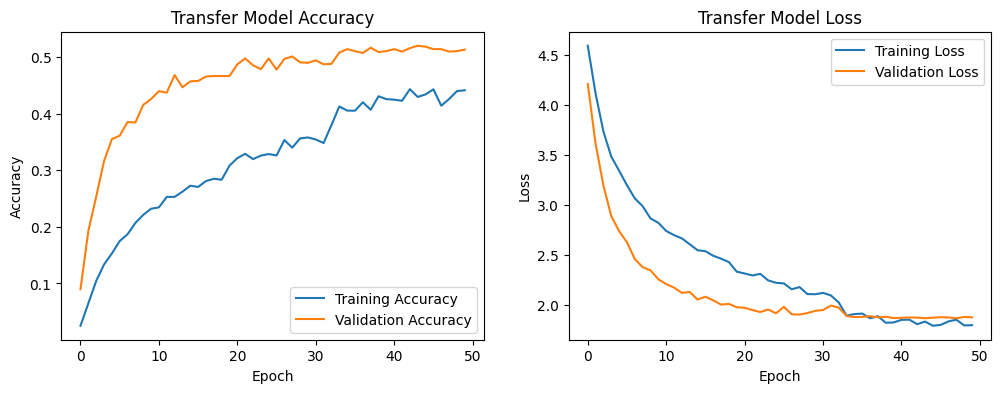

In [ ]:
# Create Accuracy and Loss Plots:

# Create a figure to display accuracy and loss plots
plt.figure(figsize=(12, 4))

# Plot the accuracy for training and validation
plt.subplot(1, 2, 1)
plt.plot(tr_model_hist.history['accuracy'], label='Training Accuracy')
plt.plot(tr_model_hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Transfer Model Accuracy')
plt.legend()

# Plot the loss for training and validation
plt.subplot(1, 2, 2)
plt.plot(tr_model_hist.history['loss'], label='Training Loss')
plt.plot(tr_model_hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Transfer Model Loss')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Evaluate transfer model on test set (50 Epochs):
transfer_model_eval = transfer_model.evaluate(test, verbose=1)

43/43 [==============================] - 2s 35ms/step - loss: 1.8465 - accuracy: 0.5211 - precision_3: 0.7746 - recall_3: 0.3202
